In [4]:
import pandas as pd
import numpy as np
from nilearn import datasets, plotting, surface
from matplotlib import colors
import matplotlib.pyplot as plt

In [5]:
import pandas as pd

# Pfad zur Excel-Datei
excel_path = "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/SCI_vs_0_Comparison_t-test_FDR_FV.xlsx"

# Versuche, die Excel-Datei einzulesen
try:
    df = pd.read_excel(excel_path)

    # Speicher als CSV
    csv_path = "/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/SCI_vs_0_Comparison_t-test_FDR_FV_converted.csv"
    df.to_csv(csv_path, index=False)

    csv_path  # Ausgabe des neuen Pfads zur konvertierten CSV
except Exception as e:
    str(e)


['lh_Unknown_thickness', 'lh_Medial_wall_thickness']
[lh] Matched 74 regions.
First few matches: ['lh_G_and_S_frontomargin_thickness', 'lh_G_and_S_occipital_inf_thickness', 'lh_G_and_S_paracentral_thickness', 'lh_G_and_S_subcentral_thickness', 'lh_G_and_S_transv_frontopol_thickness']
[rh] Matched 74 regions.
First few matches: ['rh_G_and_S_frontomargin_thickness', 'rh_G_and_S_occipital_inf_thickness', 'rh_G_and_S_paracentral_thickness', 'rh_G_and_S_subcentral_thickness', 'rh_G_and_S_transv_frontopol_thickness']


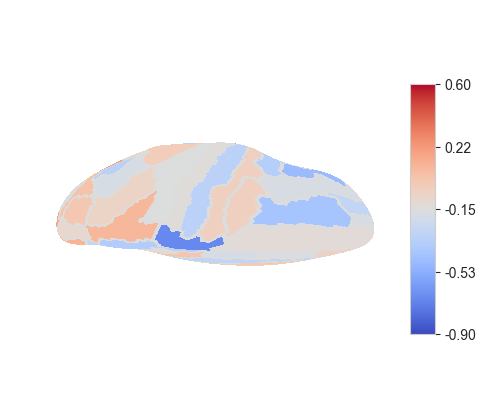

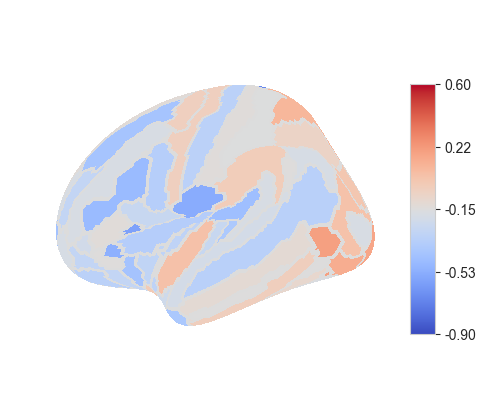

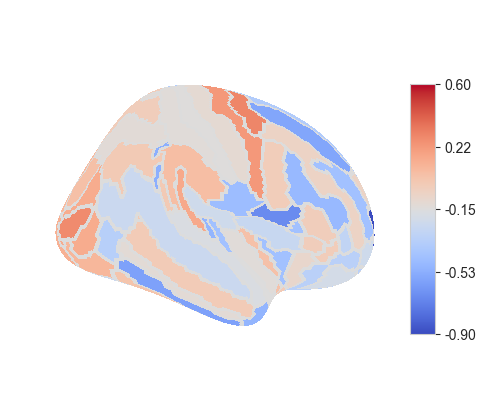

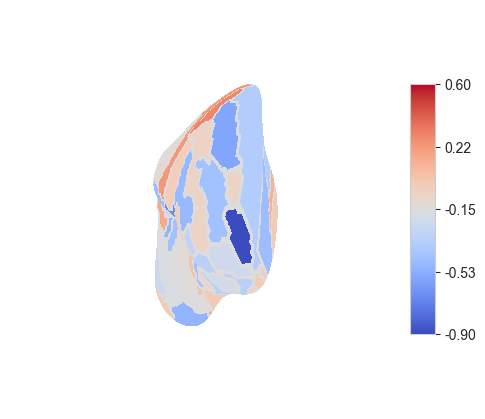

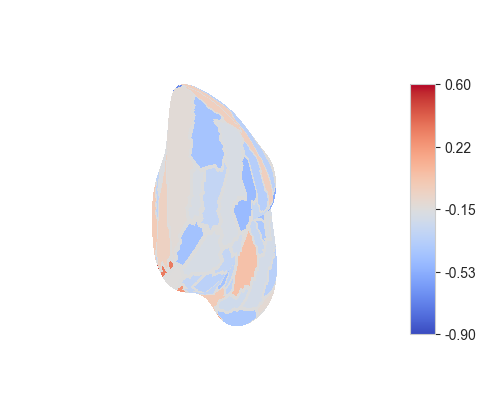

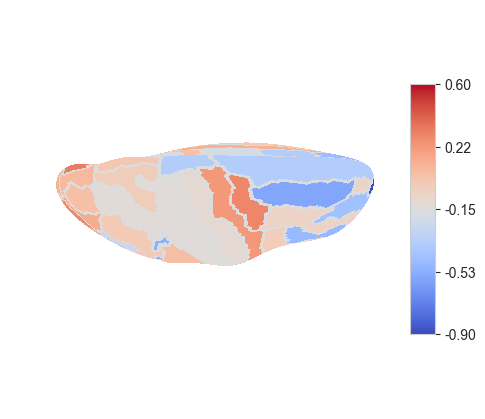

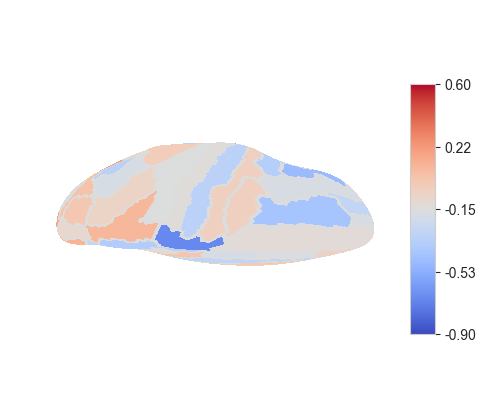

In [6]:

# Loading csv
df = pd.read_csv("/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/MasterThesis/Final_Version/SCI_vs_0_Comparison_t-test_FDR_FV_converted.csv")
df['Region'] = (
    df['Region']
    .str.replace('&', '_and_', regex=False)  # '&' zu '_and_'
    .str.replace('__', '_', regex=False)     # doppelte Unterstriche weg
    .str.strip()
)

effect_dict = dict(zip(df['Region'], df['Effect size']))

atlas = datasets.fetch_atlas_surf_destrieux()
labels_l = atlas['map_left']
labels_r = atlas['map_right']
names = atlas['labels']

def get_region_map(label_map, names, prefix):
    region_values = np.zeros_like(label_map, dtype=float)
    matched = []
    for i, name in enumerate(names):
        if name == b'Background':
            continue
        name_str = name.decode("utf-8")  # 💡 hier: Bytestring zu normalem String
        short_name = f"{prefix}_{name.decode('utf-8')}_thickness" if isinstance(name, bytes) else f"{prefix}_{name}_thickness"
        if short_name in effect_dict:
            region_values[label_map == i] = effect_dict[short_name]
            matched.append(short_name)
    print(f"[{prefix}] Matched {len(matched)} regions.")
    print("First few matches:", matched[:5])
    return region_values


regions_in_csv = set(df['Region'])

# Missing atlas
atlas_names = [
    f"lh_{name.decode('utf-8')}_thickness"
    for name in names if name != b'Background'
]

missing = [name for name in atlas_names if name not in regions_in_csv]
print(missing)


stat_map_lh = get_region_map(np.asarray(surface.load_surf_data(labels_l)), names, 'lh')
stat_map_rh = get_region_map(np.asarray(surface.load_surf_data(labels_r)), names, 'rh')

fsaverage = datasets.fetch_surf_fsaverage("fsaverage5")

# NaNs
stat_map_lh = np.nan_to_num(stat_map_lh, nan=0.0, posinf=0.0, neginf=0.0)
stat_map_rh = np.nan_to_num(stat_map_rh, nan=0.0, posinf=0.0, neginf=0.0)

'''custom_cmap = colors.LinearSegmentedColormap.from_list(
    'my_cmap', ['darkblue', 'white', 'darkred']
)'''



vmin = -0.9
vmax = 0.6
# Lade das Label-Array als int
roi_map_l = np.asarray(surface.load_surf_data(labels_l), dtype=int)
roi_map_r = np.asarray(surface.load_surf_data(labels_r), dtype=int)

# Linke Hemisphäre
fig_lh = plotting.plot_surf(
    surf_mesh=fsaverage.infl_left,
    surf_map=stat_map_lh,
    bg_map=fsaverage.sulc_left,
    hemi='left',
    view='lateral',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=False,
    darkness=0.7,
    threshold=None,
    vmin=vmin,
    vmax=vmax,
    cbar_tick_format="%.2f"
)
# Erzeuge die Liste aller einzigartigen Regionenwerte (außer 0)
unique_levels_l = np.unique(roi_map_l)
unique_levels_l = unique_levels_l[unique_levels_l != 0]

# Linke Hemisphäre – einheitliche schwarze Konturen
plotting.plot_surf_contours(
    surf_mesh=fsaverage.infl_left,
    roi_map=roi_map_l,
    levels=unique_levels_l,
    colors=['gainsboro'] * len(unique_levels_l),
    linewidths=0.5,
    axes=fig_lh.axes[0],
    figure=fig_lh
)

# Rechte Hemisphäre
fig_rh = plotting.plot_surf(
    surf_mesh=fsaverage.infl_right,
    surf_map=stat_map_rh,
    bg_map=fsaverage.sulc_right,
    hemi='right',
    view='lateral',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=False,
    darkness=0.7,
    threshold=None,
    vmin=vmin,
    vmax=vmax,
    cbar_tick_format="%.2f"
)

# Rechte Hemisphäre
unique_levels_r = np.unique(roi_map_r)
unique_levels_r = unique_levels_r[unique_levels_r != 0]

plotting.plot_surf_contours(
    surf_mesh=fsaverage.infl_right,
    roi_map=roi_map_r,
    levels=unique_levels_r,
    colors=['gainsboro'] * len(unique_levels_l),
    linewidths=[0.0]* len(unique_levels_l),
    axes=fig_rh.axes[0],
    figure=fig_rh
)

# 'anterior right'
fig_rh = plotting.plot_surf(
    surf_mesh=fsaverage.infl_right,
    surf_map=stat_map_rh,
    bg_map=fsaverage.sulc_right,
    hemi='right',
    view='anterior',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=False,
    darkness=0.7,
    threshold=None,
    vmin=vmin,
    vmax=vmax,
    cbar_tick_format="%.2f"
)

# Rechte Hemisphäre
unique_levels_r = np.unique(roi_map_r)
unique_levels_r = unique_levels_r[unique_levels_r != 0]

plotting.plot_surf_contours(
    surf_mesh=fsaverage.infl_right,
    roi_map=roi_map_r,
    levels=unique_levels_r,
    colors=['gainsboro'] * len(unique_levels_r),
    linewidths=[0.1]* len(unique_levels_r),
    axes=fig_rh.axes[0],
    figure=fig_rh
)
# 'anterior left'
fig_lh = plotting.plot_surf(
    surf_mesh=fsaverage.infl_left,
    surf_map=stat_map_lh,
    bg_map=fsaverage.sulc_left,
    hemi='left',
    view='anterior',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=False,
    darkness=0.7,
    threshold=None,
    vmin=vmin,
    vmax=vmax,
    cbar_tick_format="%.2f"
)
# Erzeuge die Liste aller einzigartigen Regionenwerte (außer 0)
unique_levels_l = np.unique(roi_map_l)
unique_levels_l = unique_levels_l[unique_levels_l != 0]

# Linke Hemisphäre – einheitliche schwarze Konturen
plotting.plot_surf_contours(
    surf_mesh=fsaverage.infl_left,
    roi_map=roi_map_l,
    levels=unique_levels_l,
    colors=['gainsboro'] * len(unique_levels_l),
    linewidths=0.1,
    axes=fig_lh.axes[0],
    figure=fig_lh
)


# 'dorsal right'
fig_rh = plotting.plot_surf(
    surf_mesh=fsaverage.infl_right,
    surf_map=stat_map_rh,
    bg_map=fsaverage.sulc_right,
    hemi='right',
    view='dorsal',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=False,
    darkness=0.7,
    threshold=None,
    vmin=vmin,
    vmax=vmax,
    cbar_tick_format="%.2f"
)

# Rechte Hemisphäre
unique_levels_r = np.unique(roi_map_r)
unique_levels_r = unique_levels_r[unique_levels_r != 0]

plotting.plot_surf_contours(
    surf_mesh=fsaverage.infl_right,
    roi_map=roi_map_r,
    levels=unique_levels_r,
    colors=['gainsboro'] * len(unique_levels_r),
    linewidths=[0.1]* len(unique_levels_r),
    axes=fig_rh.axes[0],
    figure=fig_rh
)

# 'dorsal left'
fig_lh = plotting.plot_surf(
    surf_mesh=fsaverage.infl_left,
    surf_map=stat_map_lh,
    bg_map=fsaverage.sulc_left,
    hemi='left',
    view='dorsal',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=False,
    darkness=0.7,
    threshold=None,
    vmin=vmin,
    vmax=vmax,
    cbar_tick_format="%.2f"
)
# Erzeuge die Liste aller einzigartigen Regionenwerte (außer 0)
unique_levels_l = np.unique(roi_map_l)
unique_levels_l = unique_levels_l[unique_levels_l != 0]

# Linke Hemisphäre – einheitliche schwarze Konturen
plotting.plot_surf_contours(
    surf_mesh=fsaverage.infl_left,
    roi_map=roi_map_l,
    levels=unique_levels_l,
    colors=['gainsboro'] * len(unique_levels_l),
    linewidths=0.1,
    axes=fig_lh.axes[0],
    figure=fig_lh
)


  0: Unknown
  1: G_and_S_frontomargin
  2: G_and_S_occipital_inf
  3: G_and_S_paracentral
  4: G_and_S_subcentral
  5: G_and_S_transv_frontopol
  6: G_and_S_cingul-Ant
  7: G_and_S_cingul-Mid-Ant
  8: G_and_S_cingul-Mid-Post
  9: G_cingul-Post-dorsal
 10: G_cingul-Post-ventral
 11: G_cuneus
 12: G_front_inf-Opercular
 13: G_front_inf-Orbital
 14: G_front_inf-Triangul
 15: G_front_middle
 16: G_front_sup
 17: G_Ins_lg_and_S_cent_ins
 18: G_insular_short
 19: G_occipital_middle
 20: G_occipital_sup
 21: G_oc-temp_lat-fusifor
 22: G_oc-temp_med-Lingual
 23: G_oc-temp_med-Parahip
 24: G_orbital
 25: G_pariet_inf-Angular
 26: G_pariet_inf-Supramar
 27: G_parietal_sup
 28: G_postcentral
 29: G_precentral
 30: G_precuneus
 31: G_rectus
 32: G_subcallosal
 33: G_temp_sup-G_T_transv
 34: G_temp_sup-Lateral
 35: G_temp_sup-Plan_polar
 36: G_temp_sup-Plan_tempo
 37: G_temporal_inf
 38: G_temporal_middle
 39: Lat_Fis-ant-Horizont
 40: Lat_Fis-ant-Vertical
 41: Lat_Fis-post
 42: Medial_wall
 43: P

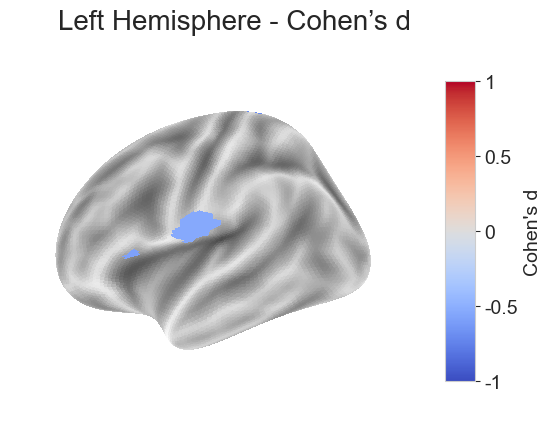

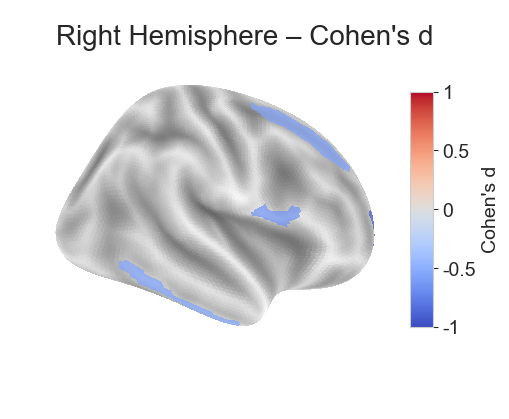

In [7]:
# FDR CORRECTION
from nilearn import datasets, surface, plotting
import numpy as np


atlas = datasets.fetch_atlas_surf_destrieux()
labels = atlas['labels']

for i, label in enumerate(labels):
    if label != b'Background':
        print(f"{i:3}: {label.decode('utf-8')}")

# 1. Lade Destrieux-Atlas und fsaverage5
atlas = datasets.fetch_atlas_surf_destrieux()
fsaverage = datasets.fetch_surf_fsaverage("fsaverage5")

labels_l = surface.load_surf_data(atlas['map_left'])
labels_r = surface.load_surf_data(atlas['map_right'])

# 2. Deine 16 Zielregionen mit korrekt gemappten Labelnamen (Bytestrings)
region_map = {
    "rh_G&S_transv_frontopol_thickness": b"G_and_S_transv_frontopol",
    "lh_G&S_paracentral_thickness": b"G_and_S_paracentral",
    "rh_G_front_inf-Opercular_thickness": b"G_front_inf-Opercular",
    "rh_G_temporal_inf_thickness": b"G_temporal_inf",
    "lh_Lat_Fis-ant-Vertical_thickness": b"Lat_Fis-ant-Vertical",
    "rh_S_front_sup_thickness": b"S_front_sup",
    "lh_G&S_subcentral_thickness": b"G_and_S_subcentral"
}


# 3. Effektgrößen in genau der richtigen Reihenfolge
effect_sizes = [
    -0.935, -0.688, -0.674, -0.584, -0.584,  -0.569, -0.539
]

# 4. Leere Oberflächen-Maps vorbereiten
roi_map_l = np.full_like(labels_l, np.nan, dtype=float)
roi_map_r = np.full_like(labels_r, np.nan, dtype=float)


# 5. Regionen eintragen
for region_key, effect in zip(region_map.keys(), effect_sizes):
    hemi = region_key[:2]
    label_name = region_map[region_key]

    if label_name not in atlas['labels']:
        print(f"[WARNUNG] Nicht gefunden: {label_name}")
        continue

    label_index = atlas['labels'].index(label_name)

    if hemi == 'lh':
        roi_map_l[labels_l == label_index] = effect
    elif hemi == 'rh':
        roi_map_r[labels_r == label_index] = effect

# Beispiel mit stat_map (mehr Kontrolle)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_left,
    stat_map=roi_map_l,
    bg_map=fsaverage.sulc_left,
    cmap='coolwarm',
    colorbar=True,
    vmin=-1,
    vmax=1,
    threshold=0,
    axes=ax,
    figure=fig
)

# Zugriff auf Farbbalken
# Zugriff auf Farbbalken
cbar_ax = fig.axes[-1]
cbar_ax.set_ylabel("Cohen's d", fontsize=14)  # ✅ Korrektur hier
cbar_ax.set_position([0.85, 0.1, 0.05, 0.8])  # ✅ Position anpassen
cbar_ax.tick_params(labelsize=14)

plt.suptitle("Left Hemisphere - Cohen’s d", fontsize=20, y=0.87)
plt.show()

# 7. Plot: Rechte Hemisphäre

fig_rh = plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_right,
    stat_map=roi_map_r,
    bg_map=fsaverage.sulc_right,
    hemi='right',
    view='lateral',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=True,
    darkness=0.6,
    vmin=-1,
    vmax=1
)
import matplotlib.pyplot as plt
# Zugriff auf Farbbalken
cbar_ax = fig_rh.axes[-1]
cbar_ax.set_ylabel("Cohen's d", fontsize=14)  # ✅ Korrektur hier
cbar_ax.set_position([0.85, 0.1, 0.05, 0.8])
cbar_ax.tick_params(labelsize=14)

plt.suptitle("Right Hemisphere – Cohen's d", fontsize=20, y=0.87)
fig_rh.axes[-1].tick_params(labelsize=14)
plt.show()

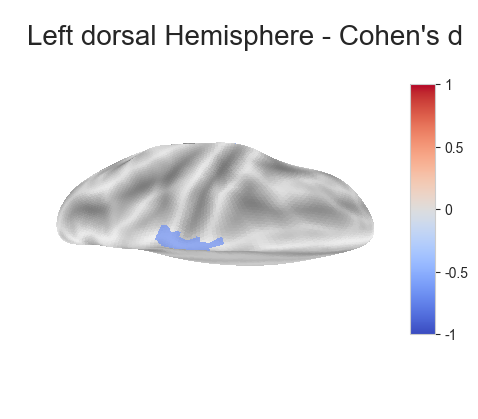

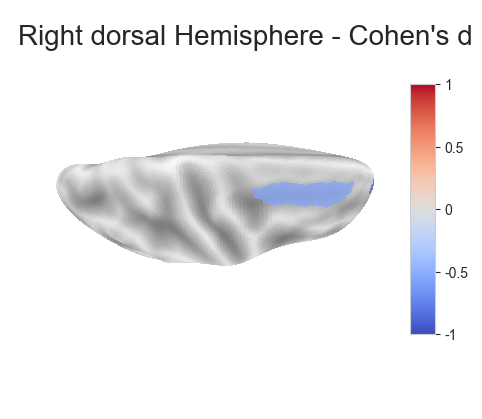

In [8]:

# 8. Plot: Linke Hemisphäre
plotting.plot_surf(
    surf_mesh=fsaverage.infl_left,
    surf_map=roi_map_l,
    bg_map=fsaverage.sulc_left,
    hemi='left',
    view='dorsal',
    cmap="coolwarm",
    colorbar=True,
    bg_on_data=True,
    darkness=0.6,
    vmin=-1,
    vmax=1
)
plt.suptitle("Left dorsal Hemisphere - Cohen's d", fontsize=20, y=0.87)
plt.show()

# 9. Plot: Rechte Hemisphäre
plotting.plot_surf(
    surf_mesh=fsaverage.infl_right,
    surf_map=roi_map_r,
    bg_map=fsaverage.sulc_right,
    hemi='right',
    view='dorsal',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=True,
    darkness=0.6,
    vmin=-1,
    vmax=1
)
plt.suptitle("Right dorsal Hemisphere - Cohen's d", fontsize=20, y=0.87)
plt.show()

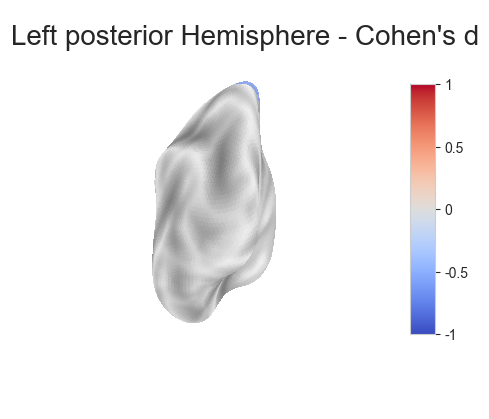

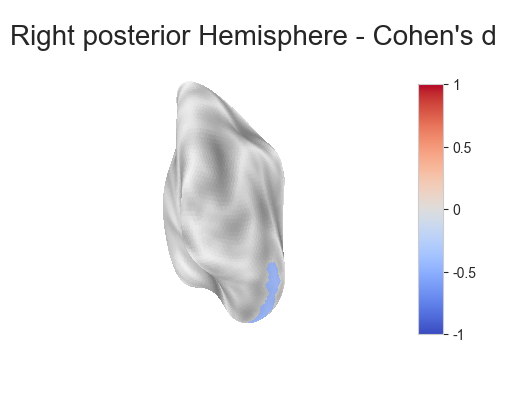

In [9]:

# 8. Plot: Linke Hemisphäre
plotting.plot_surf(
    surf_mesh=fsaverage.infl_left,
    surf_map=roi_map_l,
    bg_map=fsaverage.sulc_left,
    hemi='left',
    view='posterior',
    cmap="coolwarm",
    colorbar=True,
    bg_on_data=True,
    darkness=0.6,
    vmin=-1,
    vmax=1
)
plt.suptitle("Left posterior Hemisphere - Cohen's d", fontsize=20, y=0.87)
plt.show()

# 9. Plot: Rechte Hemisphäre
plotting.plot_surf(
    surf_mesh=fsaverage.infl_right,
    surf_map=roi_map_r,
    bg_map=fsaverage.sulc_right,
    hemi='right',
    view='posterior',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=True,
    darkness=0.6,
    vmin=-1,
    vmax=1
)
plt.suptitle("Right posterior Hemisphere - Cohen's d", fontsize=20, y=0.87)
plt.show()

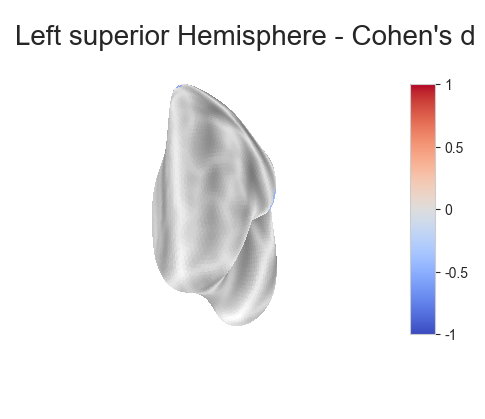

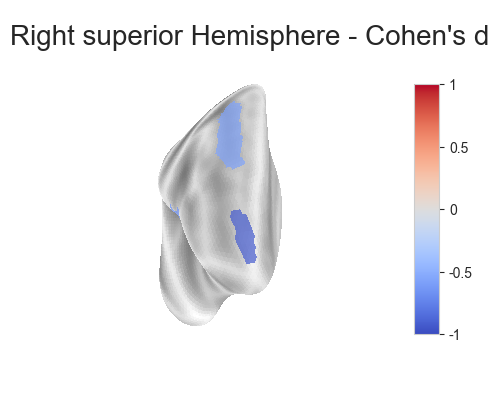

In [10]:

# 8. Plot: Linke Hemisphäre
plotting.plot_surf(
    surf_mesh=fsaverage.infl_left,
    surf_map=roi_map_l,
    bg_map=fsaverage.sulc_left,
    hemi='left',
    view='anterior',
    cmap="coolwarm",
    colorbar=True,
    bg_on_data=True,
    darkness=0.6,
    vmin=-1,
    vmax=1
)
plt.suptitle("Left superior Hemisphere - Cohen's d", fontsize=20, y=0.87)
plt.show()

# 9. Plot: Rechte Hemisphäre
plotting.plot_surf(
    surf_mesh=fsaverage.infl_right,
    surf_map=roi_map_r,
    bg_map=fsaverage.sulc_right,
    hemi='right',
    view='anterior',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=True,
    darkness=0.6,
    vmin=-1,
    vmax=1
)
plt.suptitle("Right superior Hemisphere - Cohen's d", fontsize=20, y=0.87)
plt.show()

## Subcortical Volumes

In [11]:
# import datasets module and use `fetch_atlas_basc_multiscale_2015` function
from nilearn.datasets import fetch_atlas_basc_multiscale_2015

parcellations = [
    fetch_atlas_basc_multiscale_2015(version="sym", resolution=64),
    fetch_atlas_basc_multiscale_2015(version="sym", resolution=197),
    fetch_atlas_basc_multiscale_2015(version="sym", resolution=444),
]

# We show here networks of 64, 197, 444
networks_64 = parcellations[0]["maps"]
networks_197 = parcellations[1]["maps"]
networks_444 = parcellations[2]["maps"]

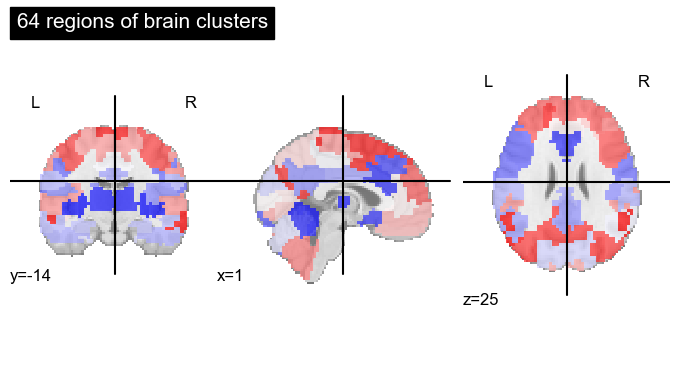

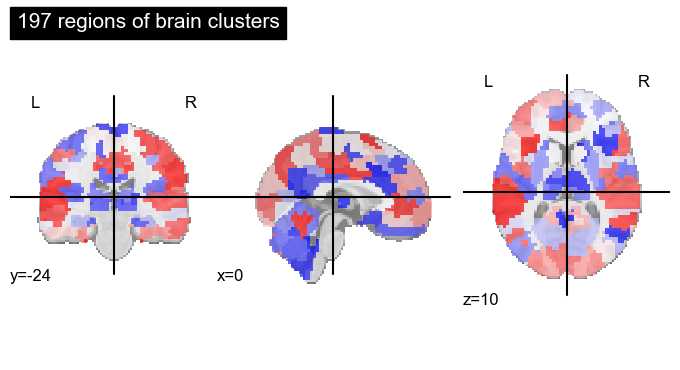

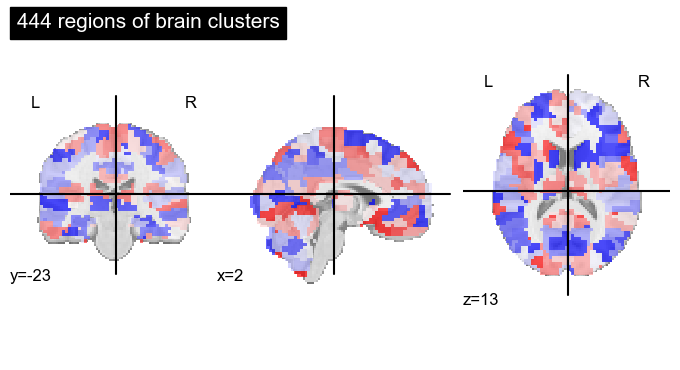

In [12]:
# import plotting module and use `plot_roi` function, since the maps are in 3D
from nilearn.plotting import plot_roi, show

# The coordinates of all plots are selected automatically by itself
# We manually change the colormap of our choice
plot_roi(networks_64, cmap="bwr", title="64 regions of brain clusters")

plot_roi(networks_197, cmap="bwr", title="197 regions of brain clusters")

plot_roi(networks_444, cmap="bwr_r", title="444 regions of brain clusters")

show()

from nilearn import datasets, plotting, image

# Atlas laden
atlas = datasets.fetch_atlas_msdl()
atlas_maps = atlas.maps  # 4D-Nifti-Bild

# Die gewünschten Komponenten (0-basiert)
indices = [1, 3, 6]

# Einzelne Regionen extrahieren und sammeln
regions = [image.index_img(atlas_maps, i) for i in indices]

# Bilder zusammenfügen (ergibt 4D-Bild mit len(indices) Komponenten)
from nilearn.image import concat_imgs
concatenated = concat_imgs(regions)

# Maximalbild erzeugen (alle Komponenten übereinanderlegen)
from nilearn.image import math_img
combined = math_img("np.max(img, axis=-1)", img=concatenated)

# Plotten
plotting.plot_stat_map(combined, title="Regionen 2, 4, 7 hervorgehoben", threshold=0.5)


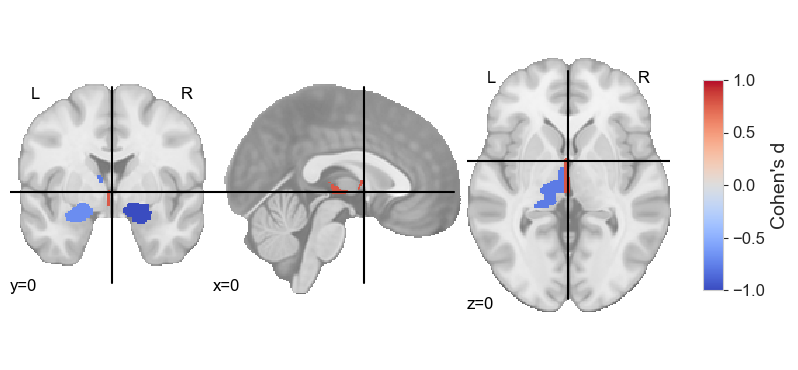

In [13]:
import nibabel as nib
import numpy as np
from nilearn import plotting
import matplotlib as mpl

# WEBSITE: https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/AnatomicalROI/FreeSurferColorLUT for codeing effect sizes

# Lade das aseg-Bild
aseg_img = nib.load("/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/07_BrainCharts/Visualization/Subject/sub-08/aseg.nii.gz")  # oder .nii
aseg_data = aseg_img.get_fdata()

# Effektgrößen definieren
effect_sizes = {
    18: -0.553,   # Left-Amygdala
    54: -0.846,  # Right-Amygdala
    14: 0.625,   # 3rd Ventricle
    10: -0.622,   # Left-Thalamus
}

# Erzeuge ein leeres Bild für die Effektgrößen
effect_map = np.zeros_like(aseg_data)

# Weisen jeder Region ihren Effektwert zu
for label, effect in effect_sizes.items():
    effect_map[aseg_data == label] = effect

# Nifti-Bild erzeugen
effect_img = nib.Nifti1Image(effect_map, affine=aseg_img.affine)

# Lade ein Hintergrundbild (z. B. MNI T1 Template)
t1 = datasets.load_mni152_template()

# Wähle Koordinaten passend zu subkortikalen Regionen
cut_coords = (0, 0, 0)

# Visualisieren mit optimierten Einstellungen
plotting.plot_stat_map(
    effect_img,
    bg_img=t1,
    #title="Effect size in subcortical regions",
    threshold=0,              # Filtert raus was < ±0.1 ist
    vmax=0.8,                   # Farben skalieren (du kannst anpassen)
    cmap="coolwarm",
    cut_coords=cut_coords,
    display_mode="ortho",
    colorbar=False,
    draw_cross=True,
    black_bg=False
)

fig = plt.gcf()
cax = fig.add_axes([1.05, 0.2, 0.03, 0.6])  # [x, y, Breite, Höhe]

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cbar = mpl.colorbar.ColorbarBase(
    cax,
    cmap='coolwarm',
    norm=norm,
    orientation='vertical'
)
cbar.set_label("Cohen's d", fontsize=14)
cbar.ax.tick_params(labelsize=12)


# Optional: Hintergrund weiß speichern
fig = plt.gcf()
fig.patch.set_facecolor('white')


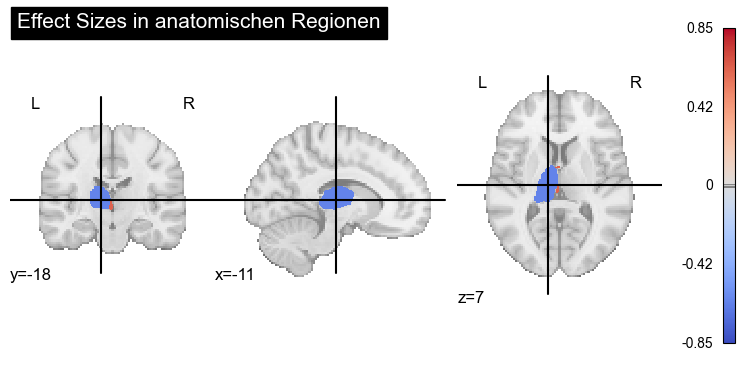

In [14]:
# Erzeuge ein leeres Bild für die Effektgrößen
effect_map = np.zeros_like(aseg_data)

# Weisen jeder Region ihren Effektwert zu
for label, effect in effect_sizes.items():
    effect_map[aseg_data == label] = effect

# Nifti-Bild erzeugen
effect_img = nib.Nifti1Image(effect_map, affine=aseg_img.affine)

# Visualisierung
plotting.plot_stat_map(effect_img,
                       title="Effect Sizes in anatomischen Regionen",
                       threshold=0.01,
                       cmap="coolwarm",
                       display_mode="ortho")

In [15]:
"""lut_path = "/Applications/freesurfer/FreeSurferColorLUT.txt"
    # Einlesen (ignoriere Kommentarzeilen)

lut = pd.read_csv(lut_path, sep=r"\s+", comment="#", header=None)
lut.columns = ["LabelID", "Label", "R", "G", "B", "A"]

# Optional: sortieren
lut = lut.sort_values("LabelID").reset_index(drop=True)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, len(lut) // 5))

for i, row in lut.iterrows():
    color = (row["R"] / 255, row["G"] / 255, row["B"] / 255)
    ax.barh(i, 1, color=color)
    ax.text(1.05, i, f'{row["LabelID"]}: {row["Label"]}', va="center")

ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0, 2)
ax.set_title("FreeSurfer Region Labels & Farben")
plt.tight_layout()
plt.show()"""

'lut_path = "/Applications/freesurfer/FreeSurferColorLUT.txt"\n    # Einlesen (ignoriere Kommentarzeilen)\n\nlut = pd.read_csv(lut_path, sep=r"\\s+", comment="#", header=None)\nlut.columns = ["LabelID", "Label", "R", "G", "B", "A"]\n\n# Optional: sortieren\nlut = lut.sort_values("LabelID").reset_index(drop=True)\nimport matplotlib.pyplot as plt\n\nfig, ax = plt.subplots(figsize=(6, len(lut) // 5))\n\nfor i, row in lut.iterrows():\n    color = (row["R"] / 255, row["G"] / 255, row["B"] / 255)\n    ax.barh(i, 1, color=color)\n    ax.text(1.05, i, f\'{row["LabelID"]}: {row["Label"]}\', va="center")\n\nax.set_yticks([])\nax.set_xticks([])\nax.set_xlim(0, 2)\nax.set_title("FreeSurfer Region Labels & Farben")\nplt.tight_layout()\nplt.show()'

### SCI pain vs 0

  0: Unknown
  1: G_and_S_frontomargin
  2: G_and_S_occipital_inf
  3: G_and_S_paracentral
  4: G_and_S_subcentral
  5: G_and_S_transv_frontopol
  6: G_and_S_cingul-Ant
  7: G_and_S_cingul-Mid-Ant
  8: G_and_S_cingul-Mid-Post
  9: G_cingul-Post-dorsal
 10: G_cingul-Post-ventral
 11: G_cuneus
 12: G_front_inf-Opercular
 13: G_front_inf-Orbital
 14: G_front_inf-Triangul
 15: G_front_middle
 16: G_front_sup
 17: G_Ins_lg_and_S_cent_ins
 18: G_insular_short
 19: G_occipital_middle
 20: G_occipital_sup
 21: G_oc-temp_lat-fusifor
 22: G_oc-temp_med-Lingual
 23: G_oc-temp_med-Parahip
 24: G_orbital
 25: G_pariet_inf-Angular
 26: G_pariet_inf-Supramar
 27: G_parietal_sup
 28: G_postcentral
 29: G_precentral
 30: G_precuneus
 31: G_rectus
 32: G_subcallosal
 33: G_temp_sup-G_T_transv
 34: G_temp_sup-Lateral
 35: G_temp_sup-Plan_polar
 36: G_temp_sup-Plan_tempo
 37: G_temporal_inf
 38: G_temporal_middle
 39: Lat_Fis-ant-Horizont
 40: Lat_Fis-ant-Vertical
 41: Lat_Fis-post
 42: Medial_wall
 43: P

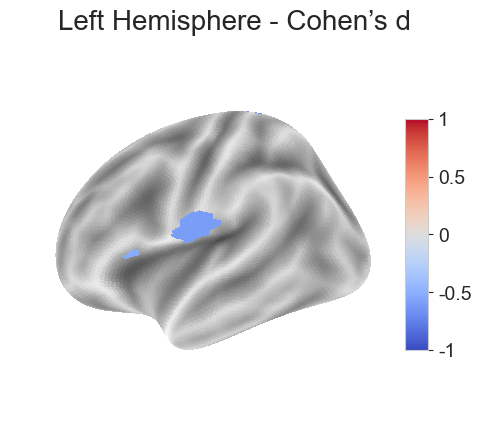

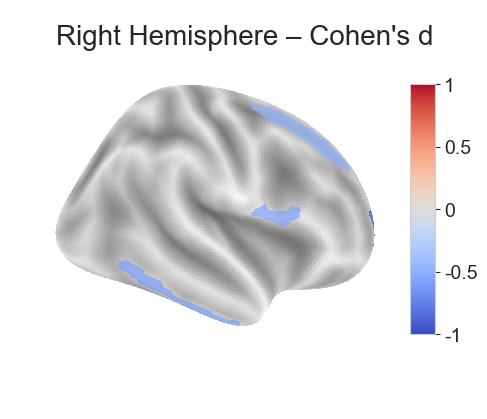

In [25]:
# FDR CORRECTION
from nilearn import datasets, surface, plotting
import numpy as np


atlas = datasets.fetch_atlas_surf_destrieux()
labels = atlas['labels']

for i, label in enumerate(labels):
    if label != b'Background':
        print(f"{i:3}: {label.decode('utf-8')}")

# 1. Lade Destrieux-Atlas und fsaverage5
atlas = datasets.fetch_atlas_surf_destrieux()
fsaverage = datasets.fetch_surf_fsaverage("fsaverage5")

labels_l = surface.load_surf_data(atlas['map_left'])
labels_r = surface.load_surf_data(atlas['map_right'])

# 2. Deine 16 Zielregionen mit korrekt gemappten Labelnamen (Bytestrings)
region_map = {
    "rh_G&S_transv_frontopol_thickness": b"G_and_S_transv_frontopol",
    "lh_G&S_paracentral_thickness": b"G_and_S_paracentral",
    "rh_G_front_inf-Opercular_thickness": b"G_front_inf-Opercular",
    "rh_G_temporal_inf_thickness": b"G_temporal_inf",
    "lh_Lat_Fis-ant-Vertical_thickness": b"Lat_Fis-ant-Vertical",
    "rh_S_front_sup_thickness": b"S_front_sup",
    "lh_G&S_subcentral_thickness": b"G_and_S_subcentral"
}


# 3. Effektgrößen in genau der richtigen Reihenfolge
effect_sizes = [-0.93, -0.677, -0.588, -0.615, -0.528,-0.471, -0.602]

# 4. Leere Oberflächen-Maps vorbereiten
roi_map_l = np.full_like(labels_l, np.nan, dtype=float)
roi_map_r = np.full_like(labels_r, np.nan, dtype=float)


# 5. Regionen eintragen
for region_key, effect in zip(region_map.keys(), effect_sizes):
    hemi = region_key[:2]
    label_name = region_map[region_key]

    if label_name not in atlas['labels']:
        print(f"[WARNUNG] Nicht gefunden: {label_name}")
        continue

    label_index = atlas['labels'].index(label_name)

    if hemi == 'lh':
        roi_map_l[labels_l == label_index] = effect
    elif hemi == 'rh':
        roi_map_r[labels_r == label_index] = effect

# Beispiel mit stat_map (mehr Kontrolle)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_left,
    stat_map=roi_map_l,
    bg_map=fsaverage.sulc_left,
    cmap='coolwarm',
    colorbar=True,
    vmin=-1,
    vmax=1,
    threshold=0,
    axes=ax,
    figure=fig
)

# Zugriff auf letzte Achse (Colorbar) und Tickgröße ändern
fig.axes[-1].tick_params(labelsize=14)
plt.suptitle("Left Hemisphere - Cohen’s d", fontsize=20, y=0.87)
plt.show()

# 7. Plot: Rechte Hemisphäre
# Beispiel mit stat_map (mehr Kontrolle)
fig_rh = plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_right,
    stat_map=roi_map_r,
    bg_map=fsaverage.sulc_right,
    hemi='right',
    view='lateral',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=True,
    darkness=0.6,
    vmin=-1,
    vmax=1
)
import matplotlib.pyplot as plt
plt.suptitle("Right Hemisphere – Cohen's d", fontsize=20, y=0.87)
fig_rh.axes[-1].tick_params(labelsize=14)
plt.show()

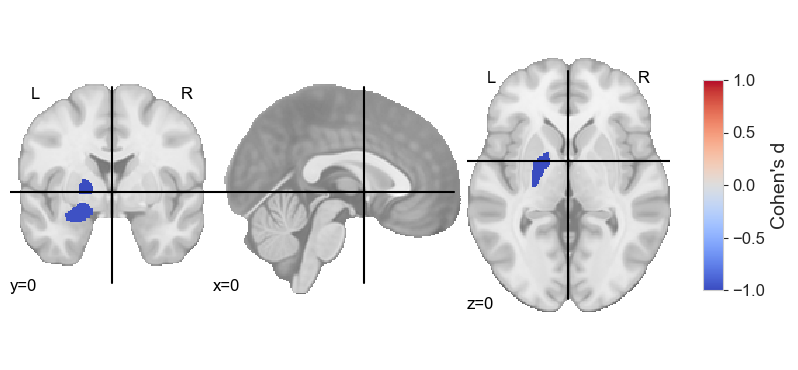

In [17]:
import nibabel as nib
import numpy as np
from nilearn import plotting

# Lade das aseg-Bild
aseg_img = nib.load("/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/07_BrainCharts/Visualization/Subject/sub-08/aseg.nii.gz")  # oder .nii
aseg_data = aseg_img.get_fdata()

# Effektgrößen definieren
effect_sizes = {
    18: -0.786,   # Left-Amygdala
    13: -0.807,  # Left-Pallidum
}

# Erzeuge ein leeres Bild für die Effektgrößen
effect_map = np.zeros_like(aseg_data)

# Weisen jeder Region ihren Effektwert zu
for label, effect in effect_sizes.items():
    effect_map[aseg_data == label] = effect

# Nifti-Bild erzeugen
effect_img = nib.Nifti1Image(effect_map, affine=aseg_img.affine)

# Lade ein Hintergrundbild (z. B. MNI T1 Template)
t1 = datasets.load_mni152_template()

# Wähle Koordinaten passend zu subkortikalen Regionen
cut_coords = (0, 0, 0)

# Visualisieren mit optimierten Einstellungen
plotting.plot_stat_map(
    effect_img,
    bg_img=t1,
    #title="Effect size in subcortical regions",
    threshold=0,              # Filtert raus was < ±0.1 ist
    vmax=0.8,                   # Farben skalieren (du kannst anpassen)
    cmap="coolwarm",
    cut_coords=cut_coords,
    display_mode="ortho",
    colorbar=False,
    draw_cross=True,
    black_bg=False
)
fig = plt.gcf()
cax = fig.add_axes([1.05, 0.2, 0.03, 0.6])  # [x, y, Breite, Höhe]

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cbar = mpl.colorbar.ColorbarBase(
    cax,
    cmap='coolwarm',
    norm=norm,
    orientation='vertical'
)
cbar.set_label("Cohen's d", fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Hintergrund auf Weiß setzen
fig = plt.gcf()
fig.patch.set_facecolor('white')


### Group Analysis on significant Regions SCI NO PAIN

  0: Unknown
  1: G_and_S_frontomargin
  2: G_and_S_occipital_inf
  3: G_and_S_paracentral
  4: G_and_S_subcentral
  5: G_and_S_transv_frontopol
  6: G_and_S_cingul-Ant
  7: G_and_S_cingul-Mid-Ant
  8: G_and_S_cingul-Mid-Post
  9: G_cingul-Post-dorsal
 10: G_cingul-Post-ventral
 11: G_cuneus
 12: G_front_inf-Opercular
 13: G_front_inf-Orbital
 14: G_front_inf-Triangul
 15: G_front_middle
 16: G_front_sup
 17: G_Ins_lg_and_S_cent_ins
 18: G_insular_short
 19: G_occipital_middle
 20: G_occipital_sup
 21: G_oc-temp_lat-fusifor
 22: G_oc-temp_med-Lingual
 23: G_oc-temp_med-Parahip
 24: G_orbital
 25: G_pariet_inf-Angular
 26: G_pariet_inf-Supramar
 27: G_parietal_sup
 28: G_postcentral
 29: G_precentral
 30: G_precuneus
 31: G_rectus
 32: G_subcallosal
 33: G_temp_sup-G_T_transv
 34: G_temp_sup-Lateral
 35: G_temp_sup-Plan_polar
 36: G_temp_sup-Plan_tempo
 37: G_temporal_inf
 38: G_temporal_middle
 39: Lat_Fis-ant-Horizont
 40: Lat_Fis-ant-Vertical
 41: Lat_Fis-post
 42: Medial_wall
 43: P

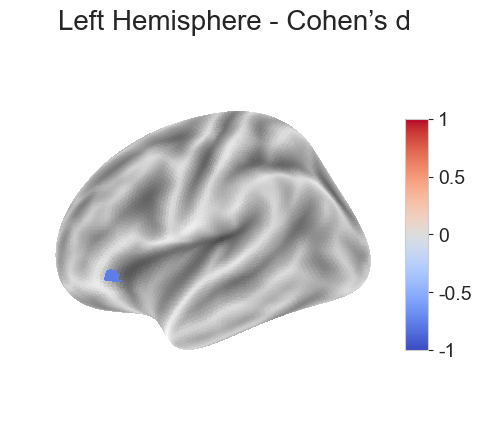

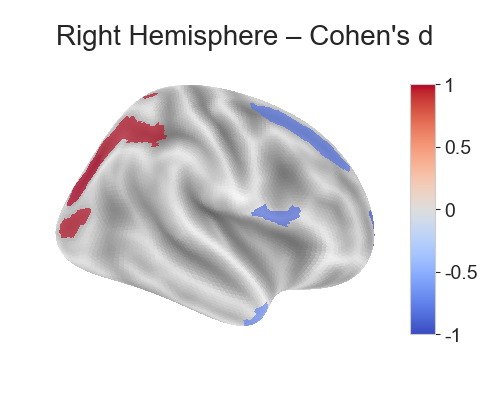

In [18]:
# FDR CORRECTION
from nilearn import datasets, surface, plotting
import numpy as np


atlas = datasets.fetch_atlas_surf_destrieux()
labels = atlas['labels']

for i, label in enumerate(labels):
    if label != b'Background':
        print(f"{i:3}: {label.decode('utf-8')}")

# 1. Lade Destrieux-Atlas und fsaverage5
atlas = datasets.fetch_atlas_surf_destrieux()
fsaverage = datasets.fetch_surf_fsaverage("fsaverage5")

labels_l = surface.load_surf_data(atlas['map_left'])
labels_r = surface.load_surf_data(atlas['map_right'])

# 2. Deine 16 Zielregionen mit korrekt gemappten Labelnamen (Bytestrings)
region_map = {
    'rh_S_oc_sup&transversal_thickness': b'S_oc_sup_and_transversal',
    'rh_G&S_transv_frontopol_thickness': b'G_and_S_transv_frontopol',
    'rh_S_oc-temp_med&Lingual_thickness': b'S_oc-temp_med_and_Lingual',
    'rh_S_oc_middle&Lunatus_thickness': b'S_oc_middle_and_Lunatus',
    'rh_S_intrapariet&P_trans_thickness': b'S_intrapariet_and_P_trans',
    'rh_G_front_inf-Opercular_thickness': b'G_front_inf-Opercular',
    'rh_S_front_sup_thickness': b'S_front_sup',
    'lh_Lat_Fis-ant-Horizont_thickness': b'Lat_Fis-ant-Horizont',
    'rh_Pole_temporal_thickness': b'Pole_temporal'
}


# 3. Effektgrößen in genau der richtigen Reihenfolge
effect_sizes = [1.135, -0.941, 1.061, 0.966, 0.964, -0.864, -0.81, -0.767, -0.719]


# 4. Leere Oberflächen-Maps vorbereiten
roi_map_l = np.full_like(labels_l, np.nan, dtype=float)
roi_map_r = np.full_like(labels_r, np.nan, dtype=float)


# 5. Regionen eintragen
for region_key, effect in zip(region_map.keys(), effect_sizes):
    hemi = region_key[:2]
    label_name = region_map[region_key]

    if label_name not in atlas['labels']:
        print(f"[WARNUNG] Nicht gefunden: {label_name}")
        continue

    label_index = atlas['labels'].index(label_name)

    if hemi == 'lh':
        roi_map_l[labels_l == label_index] = effect
    elif hemi == 'rh':
        roi_map_r[labels_r == label_index] = effect

# Beispiel mit stat_map (mehr Kontrolle)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_left,
    stat_map=roi_map_l,
    bg_map=fsaverage.sulc_left,
    cmap='coolwarm',
    colorbar=True,
    vmin=-1,
    vmax=1,
    threshold=0,
    axes=ax,
    figure=fig
)

# Zugriff auf letzte Achse (Colorbar) und Tickgröße ändern
fig.axes[-1].tick_params(labelsize=14)
plt.suptitle("Left Hemisphere - Cohen’s d", fontsize=20, y=0.87)
plt.show()

# 7. Plot: Rechte Hemisphäre
# Beispiel mit stat_map (mehr Kontrolle)
fig_rh = plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_right,
    stat_map=roi_map_r,
    bg_map=fsaverage.sulc_right,
    hemi='right',
    view='lateral',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=True,
    darkness=0.6,
    vmin=-1,
    vmax=1
)
import matplotlib.pyplot as plt
plt.suptitle("Right Hemisphere – Cohen's d", fontsize=20, y=0.87)
fig_rh.axes[-1].tick_params(labelsize=14)
plt.show()

### SCI WITH PAIN

  0: Unknown
  1: G_and_S_frontomargin
  2: G_and_S_occipital_inf
  3: G_and_S_paracentral
  4: G_and_S_subcentral
  5: G_and_S_transv_frontopol
  6: G_and_S_cingul-Ant
  7: G_and_S_cingul-Mid-Ant
  8: G_and_S_cingul-Mid-Post
  9: G_cingul-Post-dorsal
 10: G_cingul-Post-ventral
 11: G_cuneus
 12: G_front_inf-Opercular
 13: G_front_inf-Orbital
 14: G_front_inf-Triangul
 15: G_front_middle
 16: G_front_sup
 17: G_Ins_lg_and_S_cent_ins
 18: G_insular_short
 19: G_occipital_middle
 20: G_occipital_sup
 21: G_oc-temp_lat-fusifor
 22: G_oc-temp_med-Lingual
 23: G_oc-temp_med-Parahip
 24: G_orbital
 25: G_pariet_inf-Angular
 26: G_pariet_inf-Supramar
 27: G_parietal_sup
 28: G_postcentral
 29: G_precentral
 30: G_precuneus
 31: G_rectus
 32: G_subcallosal
 33: G_temp_sup-G_T_transv
 34: G_temp_sup-Lateral
 35: G_temp_sup-Plan_polar
 36: G_temp_sup-Plan_tempo
 37: G_temporal_inf
 38: G_temporal_middle
 39: Lat_Fis-ant-Horizont
 40: Lat_Fis-ant-Vertical
 41: Lat_Fis-post
 42: Medial_wall
 43: P

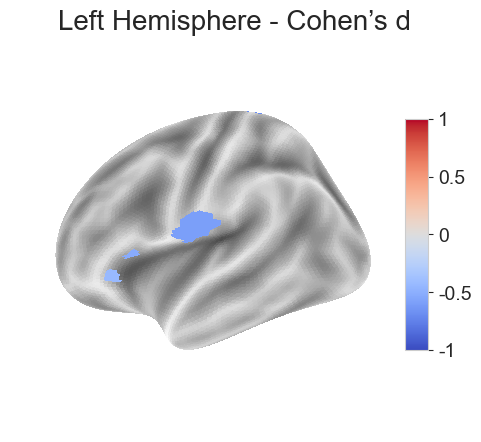

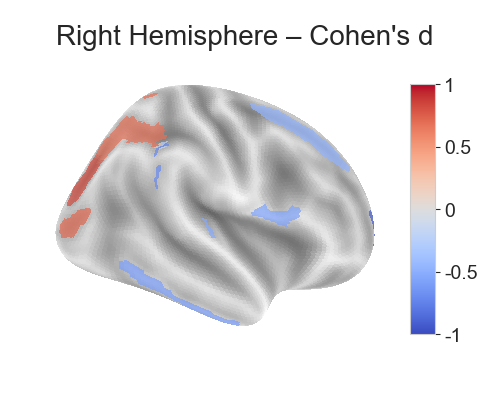

In [19]:
# FDR CORRECTION
from nilearn import datasets, surface, plotting
import numpy as np


atlas = datasets.fetch_atlas_surf_destrieux()
labels = atlas['labels']

for i, label in enumerate(labels):
    if label != b'Background':
        print(f"{i:3}: {label.decode('utf-8')}")

# 1. Lade Destrieux-Atlas und fsaverage5
atlas = datasets.fetch_atlas_surf_destrieux()
fsaverage = datasets.fetch_surf_fsaverage("fsaverage5")

labels_l = surface.load_surf_data(atlas['map_left'])
labels_r = surface.load_surf_data(atlas['map_right'])

# 2. Deine 16 Zielregionen mit korrekt gemappten Labelnamen (Bytestrings)
region_map = {
    'rh_S_oc_sup&transversal_thickness': b'S_oc_sup_and_transversal',
    'rh_G&S_transv_frontopol_thickness': b'G_and_S_transv_frontopol',
    'rh_S_oc-temp_med&Lingual_thickness': b'S_oc-temp_med_and_Lingual',
    'rh_S_oc_middle&Lunatus_thickness': b'S_oc_middle_and_Lunatus',
    'rh_S_intrapariet&P_trans_thickness': b'S_intrapariet_and_P_trans',
    'lh_G&S_paracentral_thickness': b'G_and_S_paracentral',
    'rh_G_front_inf-Opercular_thickness': b'G_front_inf-Opercular',
    'rh_G_temporal_inf_thickness': b'G_temporal_inf',
    'lh_Lat_Fis-ant-Vertical_thickness': b'Lat_Fis-ant-Vertical',
    'rh_S_front_sup_thickness': b'S_front_sup',
    'lh_G&S_subcentral_thickness': b'G_and_S_subcentral',
    'rh_S_interm_prim-Jensen_thickness': b'S_interm_prim-Jensen',
    'lh_Lat_Fis-ant-Horizont_thickness': b'Lat_Fis-ant-Horizont',
    'rh_S_temporal_transverse_thickness': b'S_temporal_transverse',
}


# 3. Effektgrößen in genau der richtigen Reihenfolge
effect_sizes = [
    0.819,-0.929, 0.844, 0.706, 0.678,  -0.684,
    -0.592,  -0.615,  -0.528,
    -0.472, -0.6, -0.71, -0.437,  -0.537
]


# 4. Leere Oberflächen-Maps vorbereiten
roi_map_l = np.full_like(labels_l, np.nan, dtype=float)
roi_map_r = np.full_like(labels_r, np.nan, dtype=float)


# 5. Regionen eintragen
for region_key, effect in zip(region_map.keys(), effect_sizes):
    hemi = region_key[:2]
    label_name = region_map[region_key]

    if label_name not in atlas['labels']:
        print(f"[WARNUNG] Nicht gefunden: {label_name}")
        continue

    label_index = atlas['labels'].index(label_name)

    if hemi == 'lh':
        roi_map_l[labels_l == label_index] = effect
    elif hemi == 'rh':
        roi_map_r[labels_r == label_index] = effect

# Beispiel mit stat_map (mehr Kontrolle)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_left,
    stat_map=roi_map_l,
    bg_map=fsaverage.sulc_left,
    cmap='coolwarm',
    colorbar=True,
    vmin=-1,
    vmax=1,
    threshold=0,
    axes=ax,
    figure=fig
)

# Zugriff auf letzte Achse (Colorbar) und Tickgröße ändern
fig.axes[-1].tick_params(labelsize=14)
plt.suptitle("Left Hemisphere - Cohen’s d", fontsize=20, y=0.87)
plt.show()

# 7. Plot: Rechte Hemisphäre
# Beispiel mit stat_map (mehr Kontrolle)
fig_rh = plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_right,
    stat_map=roi_map_r,
    bg_map=fsaverage.sulc_right,
    hemi='right',
    view='lateral',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=True,
    darkness=0.6,
    vmin=-1,
    vmax=1
)
import matplotlib.pyplot as plt
plt.suptitle("Right Hemisphere – Cohen's d", fontsize=20, y=0.87)
fig_rh.axes[-1].tick_params(labelsize=14)
plt.show()

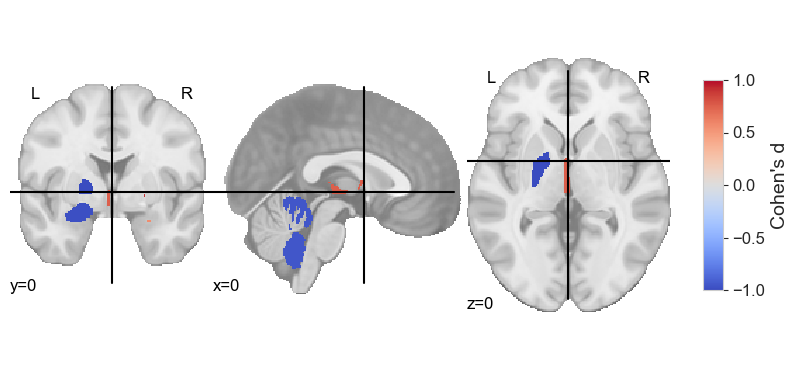

In [20]:
import nibabel as nib
import numpy as np
from nilearn import plotting
import matplotlib as mpl

# Lade das aseg-Bild
aseg_img = nib.load("/Volumes/team/INANL/56_Valentina_Haas/brain_age_centilbrain/07_BrainCharts/Visualization/Subject/sub-08/aseg.nii.gz")  # oder .nii
aseg_data = aseg_img.get_fdata()

# Effektgrößen definieren
effect_sizes = {
    18: -0.786,   # Left-Amygdala
    13: -0.807,  # Left-Pallidum
    14: 0.606,   # 3rd Ventricle
    44: 0.446,   # Right-Inf-Lat-Vent
    62: 0.726,   # Right-vessel
    47: -0.757    # Right-Cerebellum-Cortex
}

# Erzeuge ein leeres Bild für die Effektgrößen
effect_map = np.zeros_like(aseg_data)

# Weisen jeder Region ihren Effektwert zu
for label, effect in effect_sizes.items():
    effect_map[aseg_data == label] = effect

# Nifti-Bild erzeugen
effect_img = nib.Nifti1Image(effect_map, affine=aseg_img.affine)

# Lade ein Hintergrundbild (z. B. MNI T1 Template)
t1 = datasets.load_mni152_template()

# Wähle Koordinaten passend zu subkortikalen Regionen
cut_coords = (0, 0, 0)

# Visualisieren mit optimierten Einstellungen
plotting.plot_stat_map(
    effect_img,
    bg_img=t1,
    #title="Effect size in subcortical regions",
    threshold=0,              # Filtert raus was < ±0.1 ist
    vmax=0.8,                   # Farben skalieren (du kannst anpassen)
    cmap="coolwarm",
    cut_coords=cut_coords,
    display_mode="ortho",
    colorbar=False,
    draw_cross=True,
    black_bg=False
)

fig = plt.gcf()
cax = fig.add_axes([1.05, 0.2, 0.03, 0.6])  # [x, y, Breite, Höhe]

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cbar = mpl.colorbar.ColorbarBase(
    cax,
    cmap='coolwarm',
    norm=norm,
    orientation='vertical'
)
cbar.set_label("Cohen's d", fontsize=14)
cbar.ax.tick_params(labelsize=12)


# Optional: Hintergrund weiß speichern
fig = plt.gcf()
fig.patch.set_facecolor('white')


## Spearman correlation ==> PAIN

  0: Unknown
  1: G_and_S_frontomargin
  2: G_and_S_occipital_inf
  3: G_and_S_paracentral
  4: G_and_S_subcentral
  5: G_and_S_transv_frontopol
  6: G_and_S_cingul-Ant
  7: G_and_S_cingul-Mid-Ant
  8: G_and_S_cingul-Mid-Post
  9: G_cingul-Post-dorsal
 10: G_cingul-Post-ventral
 11: G_cuneus
 12: G_front_inf-Opercular
 13: G_front_inf-Orbital
 14: G_front_inf-Triangul
 15: G_front_middle
 16: G_front_sup
 17: G_Ins_lg_and_S_cent_ins
 18: G_insular_short
 19: G_occipital_middle
 20: G_occipital_sup
 21: G_oc-temp_lat-fusifor
 22: G_oc-temp_med-Lingual
 23: G_oc-temp_med-Parahip
 24: G_orbital
 25: G_pariet_inf-Angular
 26: G_pariet_inf-Supramar
 27: G_parietal_sup
 28: G_postcentral
 29: G_precentral
 30: G_precuneus
 31: G_rectus
 32: G_subcallosal
 33: G_temp_sup-G_T_transv
 34: G_temp_sup-Lateral
 35: G_temp_sup-Plan_polar
 36: G_temp_sup-Plan_tempo
 37: G_temporal_inf
 38: G_temporal_middle
 39: Lat_Fis-ant-Horizont
 40: Lat_Fis-ant-Vertical
 41: Lat_Fis-post
 42: Medial_wall
 43: P

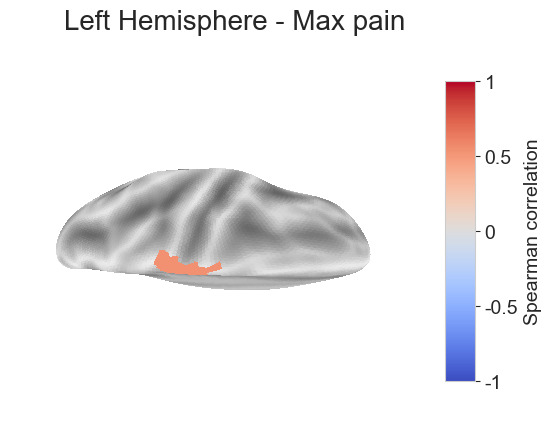

/Users/valentinahaas/SCI_Braincharts_Analysis/.venv/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:92: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
/Users/valentinahaas/SCI_Braincharts_Analysis/.venv/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:95: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)


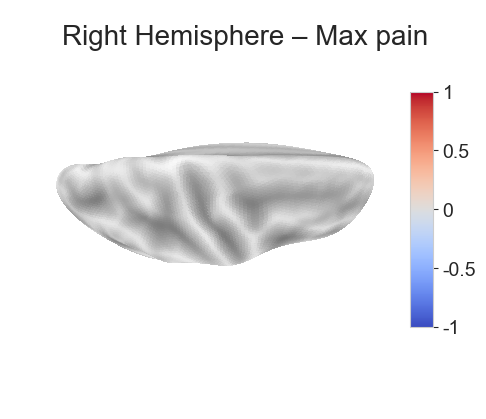

[INFO] Setze Effekt 0.543 auf Region G_and_S_paracentral (lh)


In [21]:
## Max Pain
# FDR CORRECTION
from nilearn import datasets, surface, plotting
import numpy as np


atlas = datasets.fetch_atlas_surf_destrieux()
labels = atlas['labels']

for i, label in enumerate(labels):
    if label != b'Background':
        print(f"{i:3}: {label.decode('utf-8')}")

# 1. Lade Destrieux-Atlas und fsaverage5
atlas = datasets.fetch_atlas_surf_destrieux()
fsaverage = datasets.fetch_surf_fsaverage("fsaverage5")

labels_l = surface.load_surf_data(atlas['map_left'])
labels_r = surface.load_surf_data(atlas['map_right'])

# 2. Deine 16 Zielregionen mit korrekt gemappten Labelnamen (Bytestrings)
region_map = {
    'lh_G&S_paracentral_thickness': b'G_and_S_paracentral',
}
# 3. Spearman in genau der richtigen Reihenfolge
effect_sizes = [0.543]


# 4. Leere Oberflächen-Maps vorbereiten
roi_map_l = np.full_like(labels_l, np.nan, dtype=float)
roi_map_r = np.full_like(labels_r, np.nan, dtype=float)


# 5. Regionen eintragen
for region_key, effect in zip(region_map.keys(), effect_sizes):
    hemi = region_key[:2]
    label_name = region_map[region_key]

    if label_name not in atlas['labels']:
        print(f"[WARNUNG] Nicht gefunden: {label_name}")
        continue

    label_index = atlas['labels'].index(label_name)

    if hemi == 'lh':
        roi_map_l[labels_l == label_index] = effect
    elif hemi == 'rh':
        roi_map_r[labels_r == label_index] = effect

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Speichere das Ergebnis, um die Colorbar zu bekommen
surf_plot = plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_left,
    stat_map=roi_map_l,
    bg_map=fsaverage.sulc_left,
    cmap='coolwarm',
    hemi='left',
    view='dorsal',
    colorbar=True,
    vmin=-1,
    vmax=1,
    threshold=0,
    axes=ax,
    figure=fig
)

# Die Colorbar liegt in fig.axes[-1], aber `surf_plot` enthält das Objekt
cbar_ax = fig.axes[-1]
cbar_ax.set_ylabel("Spearman correlation", fontsize=14)  # ✔️ Richtig: Achse beschriften statt nicht definiertes Objekt
cbar_ax.set_position([0.85, 0.1, 0.05, 0.8])
cbar_ax.tick_params(labelsize=14)
plt.suptitle("Left Hemisphere - Max pain", fontsize=20, y=0.87)
plt.show()

# 7. Plot: Rechte Hemisphäre

fig_rh = plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_right,
    stat_map=roi_map_r,
    bg_map=fsaverage.sulc_right,
    hemi='right',
    view='dorsal',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=True,
    darkness=0.6,
    vmin=-1,
    vmax=1
)
import matplotlib.pyplot as plt
# Zugriff auf Farbbalken
cbar_ax = fig_rh.axes[-1]

# 🛠️ Position manuell anpassen (x, y, Breite, Höhe)
cbar_ax.set_position([0.85, 0.1, 0.05, 0.8]) # Beispielwerte anpassen!

# Tick-Größe
cbar_ax.tick_params(labelsize=14)
plt.suptitle("Right Hemisphere – Max pain", fontsize=20, y=0.87)
fig_rh.axes[-1].tick_params(labelsize=14)
plt.show()
for region_key, effect in zip(region_map.keys(), effect_sizes):
    hemi = region_key[:2]
    label_name = region_map[region_key]

    if label_name not in atlas['labels']:
        print(f"[WARNUNG] Nicht gefunden: {label_name}")
        continue

    label_index = atlas['labels'].index(label_name)

    if hemi == 'lh':
        roi_map_l[labels_l == label_index] = effect
    elif hemi == 'rh':
        roi_map_r[labels_r == label_index] = effect

    print(f"[INFO] Setze Effekt {effect} auf Region {label_name.decode()} ({hemi})")


  0: Unknown
  1: G_and_S_frontomargin
  2: G_and_S_occipital_inf
  3: G_and_S_paracentral
  4: G_and_S_subcentral
  5: G_and_S_transv_frontopol
  6: G_and_S_cingul-Ant
  7: G_and_S_cingul-Mid-Ant
  8: G_and_S_cingul-Mid-Post
  9: G_cingul-Post-dorsal
 10: G_cingul-Post-ventral
 11: G_cuneus
 12: G_front_inf-Opercular
 13: G_front_inf-Orbital
 14: G_front_inf-Triangul
 15: G_front_middle
 16: G_front_sup
 17: G_Ins_lg_and_S_cent_ins
 18: G_insular_short
 19: G_occipital_middle
 20: G_occipital_sup
 21: G_oc-temp_lat-fusifor
 22: G_oc-temp_med-Lingual
 23: G_oc-temp_med-Parahip
 24: G_orbital
 25: G_pariet_inf-Angular
 26: G_pariet_inf-Supramar
 27: G_parietal_sup
 28: G_postcentral
 29: G_precentral
 30: G_precuneus
 31: G_rectus
 32: G_subcallosal
 33: G_temp_sup-G_T_transv
 34: G_temp_sup-Lateral
 35: G_temp_sup-Plan_polar
 36: G_temp_sup-Plan_tempo
 37: G_temporal_inf
 38: G_temporal_middle
 39: Lat_Fis-ant-Horizont
 40: Lat_Fis-ant-Vertical
 41: Lat_Fis-post
 42: Medial_wall
 43: P

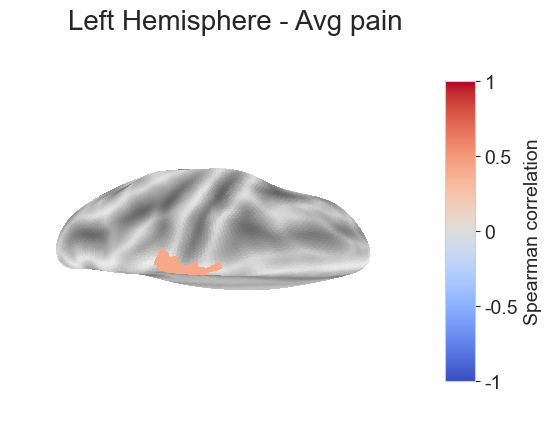

/Users/valentinahaas/SCI_Braincharts_Analysis/.venv/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:92: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
/Users/valentinahaas/SCI_Braincharts_Analysis/.venv/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:95: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)


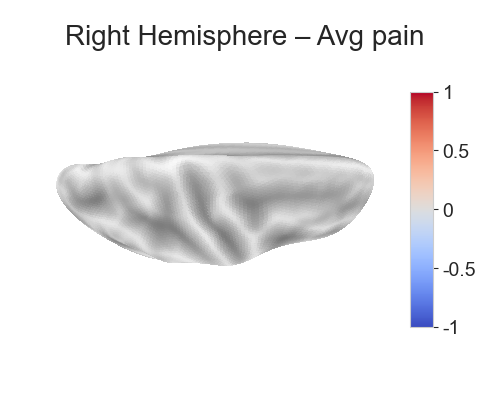

[INFO] Setze Effekt 0.426 auf Region G_and_S_paracentral (lh)


In [22]:

## Average pain
# FDR CORRECTION
from nilearn import datasets, surface, plotting
import numpy as np


atlas = datasets.fetch_atlas_surf_destrieux()
labels = atlas['labels']

for i, label in enumerate(labels):
    if label != b'Background':
        print(f"{i:3}: {label.decode('utf-8')}")

# 1. Lade Destrieux-Atlas und fsaverage5
atlas = datasets.fetch_atlas_surf_destrieux()
fsaverage = datasets.fetch_surf_fsaverage("fsaverage5")

labels_l = surface.load_surf_data(atlas['map_left'])
labels_r = surface.load_surf_data(atlas['map_right'])

# 2. Deine 16 Zielregionen mit korrekt gemappten Labelnamen (Bytestrings)
region_map = {
    'lh_G&S_paracentral_thickness': b'G_and_S_paracentral',
}
# 3. Spearman in genau der richtigen Reihenfolge
effect_sizes = [0.426]


# 4. Leere Oberflächen-Maps vorbereiten
roi_map_l = np.full_like(labels_l, np.nan, dtype=float)
roi_map_r = np.full_like(labels_r, np.nan, dtype=float)


# 5. Regionen eintragen
for region_key, effect in zip(region_map.keys(), effect_sizes):
    hemi = region_key[:2]
    label_name = region_map[region_key]

    if label_name not in atlas['labels']:
        print(f"[WARNUNG] Nicht gefunden: {label_name}")
        continue

    label_index = atlas['labels'].index(label_name)

    if hemi == 'lh':
        roi_map_l[labels_l == label_index] = effect
    elif hemi == 'rh':
        roi_map_r[labels_r == label_index] = effect

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Speichere das Ergebnis, um die Colorbar zu bekommen
surf_plot = plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_left,
    stat_map=roi_map_l,
    bg_map=fsaverage.sulc_left,
    cmap='coolwarm',
    colorbar=True,
    view='dorsal',
    vmin=-1,
    vmax=1,
    threshold=0,
    axes=ax,
    figure=fig
)

# Die Colorbar liegt in fig.axes[-1], aber `surf_plot` enthält das Objekt
cbar_ax = fig.axes[-1]
cbar_ax.set_ylabel("Spearman correlation", fontsize=14)  # ✔️ Richtig: Achse beschriften statt nicht definiertes Objekt
cbar_ax.set_position([0.85, 0.1, 0.05, 0.8])
cbar_ax.tick_params(labelsize=14)
plt.suptitle("Left Hemisphere - Avg pain", fontsize=20, y=0.87)
plt.show()

# 7. Plot: Rechte Hemisphäre

fig_rh = plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_right,
    stat_map=roi_map_r,
    bg_map=fsaverage.sulc_right,
    hemi='right',
    view='dorsal',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=True,
    darkness=0.6,
    vmin=-1,
    vmax=1
)
import matplotlib.pyplot as plt
# Zugriff auf Farbbalken
cbar_ax = fig_rh.axes[-1]

# 🛠️ Position manuell anpassen (x, y, Breite, Höhe)
cbar_ax.set_position([0.85, 0.1, 0.05, 0.8]) # Beispielwerte anpassen!

# Tick-Größe
cbar_ax.tick_params(labelsize=14)
plt.suptitle("Right Hemisphere – Avg pain", fontsize=20, y=0.87)
fig_rh.axes[-1].tick_params(labelsize=14)
plt.show()
for region_key, effect in zip(region_map.keys(), effect_sizes):
    hemi = region_key[:2]
    label_name = region_map[region_key]

    if label_name not in atlas['labels']:
        print(f"[WARNUNG] Nicht gefunden: {label_name}")
        continue

    label_index = atlas['labels'].index(label_name)

    if hemi == 'lh':
        roi_map_l[labels_l == label_index] = effect
    elif hemi == 'rh':
        roi_map_r[labels_r == label_index] = effect

    print(f"[INFO] Setze Effekt {effect} auf Region {label_name.decode()} ({hemi})")


  0: Unknown
  1: G_and_S_frontomargin
  2: G_and_S_occipital_inf
  3: G_and_S_paracentral
  4: G_and_S_subcentral
  5: G_and_S_transv_frontopol
  6: G_and_S_cingul-Ant
  7: G_and_S_cingul-Mid-Ant
  8: G_and_S_cingul-Mid-Post
  9: G_cingul-Post-dorsal
 10: G_cingul-Post-ventral
 11: G_cuneus
 12: G_front_inf-Opercular
 13: G_front_inf-Orbital
 14: G_front_inf-Triangul
 15: G_front_middle
 16: G_front_sup
 17: G_Ins_lg_and_S_cent_ins
 18: G_insular_short
 19: G_occipital_middle
 20: G_occipital_sup
 21: G_oc-temp_lat-fusifor
 22: G_oc-temp_med-Lingual
 23: G_oc-temp_med-Parahip
 24: G_orbital
 25: G_pariet_inf-Angular
 26: G_pariet_inf-Supramar
 27: G_parietal_sup
 28: G_postcentral
 29: G_precentral
 30: G_precuneus
 31: G_rectus
 32: G_subcallosal
 33: G_temp_sup-G_T_transv
 34: G_temp_sup-Lateral
 35: G_temp_sup-Plan_polar
 36: G_temp_sup-Plan_tempo
 37: G_temporal_inf
 38: G_temporal_middle
 39: Lat_Fis-ant-Horizont
 40: Lat_Fis-ant-Vertical
 41: Lat_Fis-post
 42: Medial_wall
 43: P

/Users/valentinahaas/SCI_Braincharts_Analysis/.venv/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:92: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
/Users/valentinahaas/SCI_Braincharts_Analysis/.venv/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:95: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)


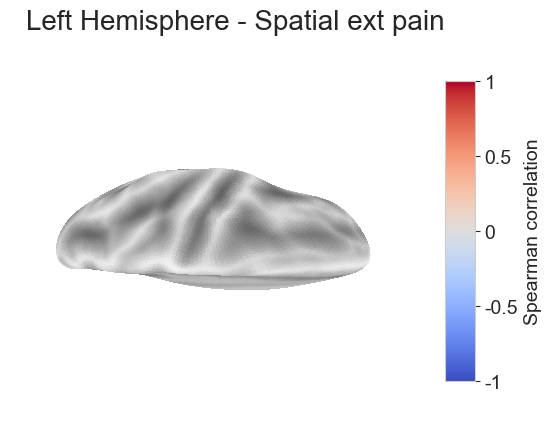

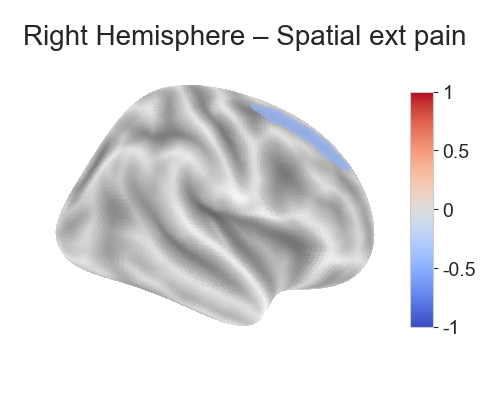

[INFO] Setze Effekt -0.466 auf Region S_front_sup (rh)


In [23]:



##Spatial ext pain
# FDR CORRECTION
from nilearn import datasets, surface, plotting
import numpy as np


atlas = datasets.fetch_atlas_surf_destrieux()
labels = atlas['labels']

for i, label in enumerate(labels):
    if label != b'Background':
        print(f"{i:3}: {label.decode('utf-8')}")

# 1. Lade Destrieux-Atlas und fsaverage5
atlas = datasets.fetch_atlas_surf_destrieux()
fsaverage = datasets.fetch_surf_fsaverage("fsaverage5")

labels_l = surface.load_surf_data(atlas['map_left'])
labels_r = surface.load_surf_data(atlas['map_right'])

# 2. Deine 16 Zielregionen mit korrekt gemappten Labelnamen (Bytestrings)
region_map = {
    'rh_S_front_sup_thickness': b'S_front_sup'
}
# 3. Spearman in genau der richtigen Reihenfolge
effect_sizes = [-0.466]


# 4. Leere Oberflächen-Maps vorbereiten
roi_map_l = np.full_like(labels_l, np.nan, dtype=float)
roi_map_r = np.full_like(labels_r, np.nan, dtype=float)


# 5. Regionen eintragen
for region_key, effect in zip(region_map.keys(), effect_sizes):
    hemi = region_key[:2]
    label_name = region_map[region_key]

    if label_name not in atlas['labels']:
        print(f"[WARNUNG] Nicht gefunden: {label_name}")
        continue

    label_index = atlas['labels'].index(label_name)

    if hemi == 'lh':
        roi_map_l[labels_l == label_index] = effect
    elif hemi == 'rh':
        roi_map_r[labels_r == label_index] = effect

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Speichere das Ergebnis, um die Colorbar zu bekommen
surf_plot = plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_left,
    stat_map=roi_map_l,
    bg_map=fsaverage.sulc_left,
    cmap='coolwarm',
    colorbar=True,
    view='dorsal',
    vmin=-1,
    vmax=1,
    threshold=0,
    axes=ax,
    figure=fig
)

# Die Colorbar liegt in fig.axes[-1], aber `surf_plot` enthält das Objekt
cbar_ax = fig.axes[-1]
cbar_ax.set_ylabel("Spearman correlation", fontsize=14)  # ✔️ Richtig: Achse beschriften statt nicht definiertes Objekt
cbar_ax.set_position([0.85, 0.1, 0.05, 0.8])
cbar_ax.tick_params(labelsize=14)
plt.suptitle("Left Hemisphere - Spatial ext pain", fontsize=20, y=0.87)
plt.show()

# 7. Plot: Rechte Hemisphäre

fig_rh = plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_right,
    stat_map=roi_map_r,
    bg_map=fsaverage.sulc_right,
    hemi='right',
    view='lateral',
    cmap='coolwarm',
    colorbar=True,
    bg_on_data=True,
    darkness=0.6,
    vmin=-1,
    vmax=1
)
import matplotlib.pyplot as plt
# Zugriff auf Farbbalken
cbar_ax = fig_rh.axes[-1]

# 🛠️ Position manuell anpassen (x, y, Breite, Höhe)
cbar_ax.set_position([0.85, 0.1, 0.05, 0.8]) # Beispielwerte anpassen!

# Tick-Größe
cbar_ax.tick_params(labelsize=14)
plt.suptitle("Right Hemisphere – Spatial ext pain", fontsize=20, y=0.87)
fig_rh.axes[-1].tick_params(labelsize=14)
plt.show()
for region_key, effect in zip(region_map.keys(), effect_sizes):
    hemi = region_key[:2]
    label_name = region_map[region_key]

    if label_name not in atlas['labels']:
        print(f"[WARNUNG] Nicht gefunden: {label_name}")
        continue

    label_index = atlas['labels'].index(label_name)

    if hemi == 'lh':
        roi_map_l[labels_l == label_index] = effect
    elif hemi == 'rh':
        roi_map_r[labels_r == label_index] = effect

    print(f"[INFO] Setze Effekt {effect} auf Region {label_name.decode()} ({hemi})")
